In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import os
import random
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
train_path = 'birds/train'
valid_path =  'birds/valid'
test_path = 'birds/test'

Number of classes: 525


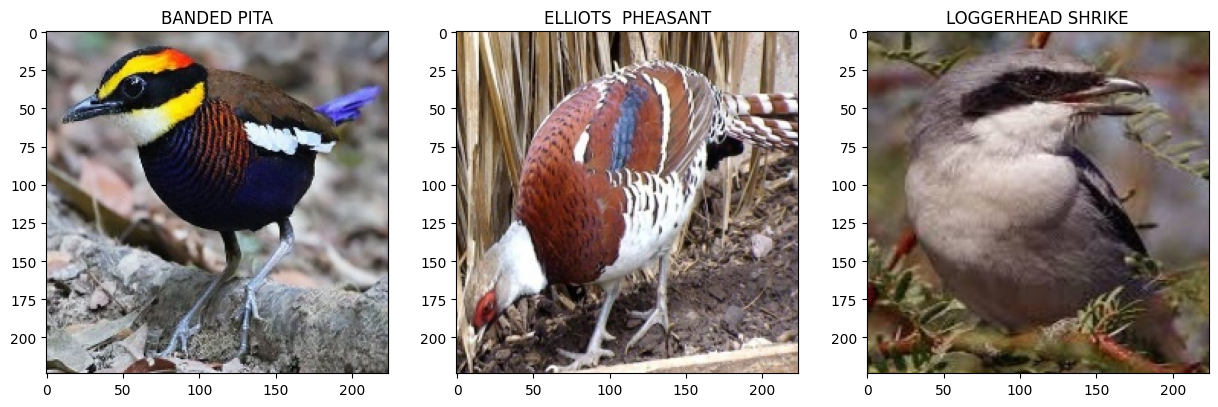

In [3]:
print(f'Number of classes: {len(os.listdir("birds/train"))}')
def plot_random_image():
    random_class = random.sample(os.listdir(train_path), 1)
    random_img = random.sample(os.listdir(train_path + '/' + random_class[0]), 1)
    img = mpimg.imread(train_path + '/' + random_class[0] + '/' + random_img[0])

    plt.imshow(img)
    plt.title(random_class[0])
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plot_random_image()

plt.subplot(2,3,2)
plot_random_image()

plt.subplot(2,3,3)
plot_random_image()


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
image_size = (224, 224)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer"))

model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))


model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))


model.add(tf.keras.layers.Dense(525, activation="softmax", name="output-layer"))



base_learning_rate = 0.01 

adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate)

# Compile the model 
model.compile(
    loss="categorical_crossentropy",
    optimizer=adam_optimizer,
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_94 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0.001,
    restore_best_weights=True,)


history = model.fit(
    train_generator,
    epochs=18,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=int(0.25 * len(validation_generator)),
    callbacks=[early_stop],
)

Epoch 1/18
2645/2645 [==============================] - 1279s 484ms/step - loss: 2.9173 - accuracy: 0.3292 - val_loss: 1.3503 - val_accuracy: 0.6297
Epoch 2/18
2645/2645 [==============================] - 1265s 478ms/step - loss: 2.1334 - accuracy: 0.4694 - val_loss: 1.1423 - val_accuracy: 0.6953
Epoch 3/18
2645/2645 [==============================] - 1195s 452ms/step - loss: 1.9582 - accuracy: 0.5083 - val_loss: 1.0343 - val_accuracy: 0.7016
Epoch 4/18
2645/2645 [==============================] - 1167s 441ms/step - loss: 1.8608 - accuracy: 0.5338 - val_loss: 0.9156 - val_accuracy: 0.7437
Epoch 5/18
2645/2645 [==============================] - 1132s 428ms/step - loss: 1.7957 - accuracy: 0.5500 - val_loss: 0.8327 - val_accuracy: 0.7766
Epoch 6/18
2645/2645 [==============================] - 1146s 433ms/step - loss: 1.7395 - accuracy: 0.5627 - val_loss: 0.8677 - val_accuracy: 0.7547
Epoch 7/18
2645/2645 [==============================] - 1171s 443ms/step - loss: 1.6961 - accuracy: 0.5719

In [9]:
fine_tune_at = 270
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [10]:
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate/100)

model.compile(
    loss="categorical_crossentropy",
    optimizer=adam_optimizer,
    metrics=["accuracy"]
)

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=4,
    min_delta=0.001,
    restore_best_weights=True,)


fine_tune_epochs = 12
total_epochs =  18 + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         steps_per_epoch=len(train_generator),
                         validation_data=validation_generator,
                         validation_steps=int(0.25 * len(validation_generator)),
                         callbacks=[early_stop])

NameError: name 'model' is not defined

In [9]:
model.save('bird_classifier/model.keras')

NameError: name 'model' is not defined

In [13]:
from tensorflow.keras.models import load_model
model =  tf.keras.models.load_model('bird_classifier/model.keras 19-15-13-428.keras')


TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'inception_v3_input'}, 'registered_name': None}, {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'inception_v3', 'trainable': False, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv2d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 111, 111, 32]}, 'name': 'batch_normalization', 'inbound_nodes': [[['conv2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 111, 111, 32]}, 'name': 'activation', 'inbound_nodes': [[['batch_normalization', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 111, 111, 32]}, 'name': 'conv2d_1', 'inbound_nodes': [[['activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 32]}, 'name': 'batch_normalization_1', 'inbound_nodes': [[['conv2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_1', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 32]}, 'name': 'activation_1', 'inbound_nodes': [[['batch_normalization_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 32]}, 'name': 'conv2d_2', 'inbound_nodes': [[['activation_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 64]}, 'name': 'batch_normalization_2', 'inbound_nodes': [[['conv2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_2', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 64]}, 'name': 'activation_2', 'inbound_nodes': [[['batch_normalization_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 64]}, 'name': 'max_pooling2d', 'inbound_nodes': [[['activation_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': False, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 64]}, 'name': 'conv2d_3', 'inbound_nodes': [[['max_pooling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 80]}, 'name': 'batch_normalization_3', 'inbound_nodes': [[['conv2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_3', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 80]}, 'name': 'activation_3', 'inbound_nodes': [[['batch_normalization_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 80]}, 'name': 'conv2d_4', 'inbound_nodes': [[['activation_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 52, 52, 192]}, 'name': 'batch_normalization_4', 'inbound_nodes': [[['conv2d_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_4', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 52, 52, 192]}, 'name': 'activation_4', 'inbound_nodes': [[['batch_normalization_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 52, 52, 192]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [[['activation_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_8', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_8', 'inbound_nodes': [[['conv2d_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_8', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_8', 'inbound_nodes': [[['batch_normalization_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': False, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_6', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_9', 'inbound_nodes': [[['activation_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'batch_normalization_6', 'inbound_nodes': [[['conv2d_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_9', 'inbound_nodes': [[['conv2d_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_6', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'activation_6', 'inbound_nodes': [[['batch_normalization_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_9', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_9', 'inbound_nodes': [[['batch_normalization_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'average_pooling2d', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_5', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'conv2d_7', 'inbound_nodes': [[['activation_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_10', 'inbound_nodes': [[['activation_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_11', 'inbound_nodes': [[['average_pooling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_5', 'inbound_nodes': [[['conv2d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_7', 'inbound_nodes': [[['conv2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_10', 'inbound_nodes': [[['conv2d_10', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 32]}, 'name': 'batch_normalization_11', 'inbound_nodes': [[['conv2d_11', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_5', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_5', 'inbound_nodes': [[['batch_normalization_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_7', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_7', 'inbound_nodes': [[['batch_normalization_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_10', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_10', 'inbound_nodes': [[['batch_normalization_10', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_11', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 32]}, 'name': 'activation_11', 'inbound_nodes': [[['batch_normalization_11', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed0', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 25, 25, 64], [None, 25, 25, 64], [None, 25, 25, 96], [None, 25, 25, 32]]}, 'name': 'mixed0', 'inbound_nodes': [[['activation_5', 0, 0, {}], ['activation_7', 0, 0, {}], ['activation_10', 0, 0, {}], ['activation_11', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_15', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_15', 'inbound_nodes': [[['conv2d_15', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_15', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_15', 'inbound_nodes': [[['batch_normalization_15', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': False, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_13', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_16', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_16', 'inbound_nodes': [[['activation_15', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'batch_normalization_13', 'inbound_nodes': [[['conv2d_13', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_16', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_16', 'inbound_nodes': [[['conv2d_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_13', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'activation_13', 'inbound_nodes': [[['batch_normalization_13', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_16', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_16', 'inbound_nodes': [[['batch_normalization_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_1', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'average_pooling2d_1', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_12', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'conv2d_14', 'inbound_nodes': [[['activation_13', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_17', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_17', 'inbound_nodes': [[['activation_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_18', 'inbound_nodes': [[['average_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_12', 'inbound_nodes': [[['conv2d_12', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_14', 'inbound_nodes': [[['conv2d_14', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_17', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_17', 'inbound_nodes': [[['conv2d_17', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_18', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_18', 'inbound_nodes': [[['conv2d_18', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_12', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_12', 'inbound_nodes': [[['batch_normalization_12', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_14', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_14', 'inbound_nodes': [[['batch_normalization_14', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_17', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_17', 'inbound_nodes': [[['batch_normalization_17', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_18', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_18', 'inbound_nodes': [[['batch_normalization_18', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed1', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 25, 25, 64], [None, 25, 25, 64], [None, 25, 25, 96], [None, 25, 25, 64]]}, 'name': 'mixed1', 'inbound_nodes': [[['activation_12', 0, 0, {}], ['activation_14', 0, 0, {}], ['activation_17', 0, 0, {}], ['activation_18', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_22', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_22', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_22', 'inbound_nodes': [[['conv2d_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_22', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_22', 'inbound_nodes': [[['batch_normalization_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_20', 'trainable': False, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_20', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_23', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_23', 'inbound_nodes': [[['activation_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_20', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'batch_normalization_20', 'inbound_nodes': [[['conv2d_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_23', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_23', 'inbound_nodes': [[['conv2d_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_20', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'activation_20', 'inbound_nodes': [[['batch_normalization_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_23', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_23', 'inbound_nodes': [[['batch_normalization_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_2', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'average_pooling2d_2', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_19', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_21', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'conv2d_21', 'inbound_nodes': [[['activation_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_24', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_24', 'inbound_nodes': [[['activation_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_25', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_25', 'inbound_nodes': [[['average_pooling2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_19', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_19', 'inbound_nodes': [[['conv2d_19', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_21', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_21', 'inbound_nodes': [[['conv2d_21', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_24', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_24', 'inbound_nodes': [[['conv2d_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_25', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_25', 'inbound_nodes': [[['conv2d_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_19', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_19', 'inbound_nodes': [[['batch_normalization_19', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_21', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_21', 'inbound_nodes': [[['batch_normalization_21', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_24', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_24', 'inbound_nodes': [[['batch_normalization_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_25', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_25', 'inbound_nodes': [[['batch_normalization_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed2', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 25, 25, 64], [None, 25, 25, 64], [None, 25, 25, 96], [None, 25, 25, 64]]}, 'name': 'mixed2', 'inbound_nodes': [[['activation_19', 0, 0, {}], ['activation_21', 0, 0, {}], ['activation_24', 0, 0, {}], ['activation_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_27', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_27', 'inbound_nodes': [[['mixed2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_27', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_27', 'inbound_nodes': [[['conv2d_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_27', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_27', 'inbound_nodes': [[['batch_normalization_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_28', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_28', 'inbound_nodes': [[['activation_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_28', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_28', 'inbound_nodes': [[['conv2d_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_28', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_28', 'inbound_nodes': [[['batch_normalization_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_26', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_26', 'inbound_nodes': [[['mixed2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_29', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_29', 'inbound_nodes': [[['activation_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_26', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 384]}, 'name': 'batch_normalization_26', 'inbound_nodes': [[['conv2d_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_29', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 96]}, 'name': 'batch_normalization_29', 'inbound_nodes': [[['conv2d_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_26', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 384]}, 'name': 'activation_26', 'inbound_nodes': [[['batch_normalization_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_29', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 96]}, 'name': 'activation_29', 'inbound_nodes': [[['batch_normalization_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [[['mixed2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed3', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 384], [None, 12, 12, 96], [None, 12, 12, 288]]}, 'name': 'mixed3', 'inbound_nodes': [[['activation_26', 0, 0, {}], ['activation_29', 0, 0, {}], ['max_pooling2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_34', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_34', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_34', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_34', 'inbound_nodes': [[['conv2d_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_34', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_34', 'inbound_nodes': [[['batch_normalization_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_35', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_35', 'inbound_nodes': [[['activation_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_35', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_35', 'inbound_nodes': [[['conv2d_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_35', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_35', 'inbound_nodes': [[['batch_normalization_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_31', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_31', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_36', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_36', 'inbound_nodes': [[['activation_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_31', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_31', 'inbound_nodes': [[['conv2d_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_36', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_36', 'inbound_nodes': [[['conv2d_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_31', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_31', 'inbound_nodes': [[['batch_normalization_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_36', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_36', 'inbound_nodes': [[['batch_normalization_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_32', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_32', 'inbound_nodes': [[['activation_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_37', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_37', 'inbound_nodes': [[['activation_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_32', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_32', 'inbound_nodes': [[['conv2d_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_37', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_37', 'inbound_nodes': [[['conv2d_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_32', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_32', 'inbound_nodes': [[['batch_normalization_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_37', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_37', 'inbound_nodes': [[['batch_normalization_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_3', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_3', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_30', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_30', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_33', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_33', 'inbound_nodes': [[['activation_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_38', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_38', 'inbound_nodes': [[['activation_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_39', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_39', 'inbound_nodes': [[['average_pooling2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_30', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_30', 'inbound_nodes': [[['conv2d_30', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_33', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_33', 'inbound_nodes': [[['conv2d_33', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_38', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_38', 'inbound_nodes': [[['conv2d_38', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_39', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_39', 'inbound_nodes': [[['conv2d_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_30', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_30', 'inbound_nodes': [[['batch_normalization_30', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_33', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_33', 'inbound_nodes': [[['batch_normalization_33', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_38', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_38', 'inbound_nodes': [[['batch_normalization_38', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_39', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_39', 'inbound_nodes': [[['batch_normalization_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed4', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed4', 'inbound_nodes': [[['activation_30', 0, 0, {}], ['activation_33', 0, 0, {}], ['activation_38', 0, 0, {}], ['activation_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_44', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_44', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_44', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_44', 'inbound_nodes': [[['conv2d_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_44', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_44', 'inbound_nodes': [[['batch_normalization_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_45', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_45', 'inbound_nodes': [[['activation_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_45', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_45', 'inbound_nodes': [[['conv2d_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_45', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_45', 'inbound_nodes': [[['batch_normalization_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_41', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_41', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_46', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_46', 'inbound_nodes': [[['activation_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_41', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_41', 'inbound_nodes': [[['conv2d_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_46', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_46', 'inbound_nodes': [[['conv2d_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_41', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_41', 'inbound_nodes': [[['batch_normalization_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_46', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_46', 'inbound_nodes': [[['batch_normalization_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_42', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_42', 'inbound_nodes': [[['activation_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_47', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_47', 'inbound_nodes': [[['activation_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_42', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_42', 'inbound_nodes': [[['conv2d_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_47', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_47', 'inbound_nodes': [[['conv2d_47', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_42', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_42', 'inbound_nodes': [[['batch_normalization_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_47', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_47', 'inbound_nodes': [[['batch_normalization_47', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_4', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_4', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_40', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_40', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_43', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_43', 'inbound_nodes': [[['activation_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_48', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_48', 'inbound_nodes': [[['activation_47', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_49', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_49', 'inbound_nodes': [[['average_pooling2d_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_40', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_40', 'inbound_nodes': [[['conv2d_40', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_43', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_43', 'inbound_nodes': [[['conv2d_43', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_48', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_48', 'inbound_nodes': [[['conv2d_48', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_49', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_49', 'inbound_nodes': [[['conv2d_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_40', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_40', 'inbound_nodes': [[['batch_normalization_40', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_43', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_43', 'inbound_nodes': [[['batch_normalization_43', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_48', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_48', 'inbound_nodes': [[['batch_normalization_48', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_49', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_49', 'inbound_nodes': [[['batch_normalization_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed5', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed5', 'inbound_nodes': [[['activation_40', 0, 0, {}], ['activation_43', 0, 0, {}], ['activation_48', 0, 0, {}], ['activation_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_54', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_54', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_54', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_54', 'inbound_nodes': [[['conv2d_54', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_54', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_54', 'inbound_nodes': [[['batch_normalization_54', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_55', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_55', 'inbound_nodes': [[['activation_54', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_55', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_55', 'inbound_nodes': [[['conv2d_55', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_55', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_55', 'inbound_nodes': [[['batch_normalization_55', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_51', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_51', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_56', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_56', 'inbound_nodes': [[['activation_55', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_51', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_51', 'inbound_nodes': [[['conv2d_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_56', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_56', 'inbound_nodes': [[['conv2d_56', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_51', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_51', 'inbound_nodes': [[['batch_normalization_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_56', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_56', 'inbound_nodes': [[['batch_normalization_56', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_52', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_52', 'inbound_nodes': [[['activation_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_57', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_57', 'inbound_nodes': [[['activation_56', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_52', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_52', 'inbound_nodes': [[['conv2d_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_57', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_57', 'inbound_nodes': [[['conv2d_57', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_52', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_52', 'inbound_nodes': [[['batch_normalization_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_57', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_57', 'inbound_nodes': [[['batch_normalization_57', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_5', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_5', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_50', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_50', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_53', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_53', 'inbound_nodes': [[['activation_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_58', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_58', 'inbound_nodes': [[['activation_57', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_59', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_59', 'inbound_nodes': [[['average_pooling2d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_50', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_50', 'inbound_nodes': [[['conv2d_50', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_53', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_53', 'inbound_nodes': [[['conv2d_53', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_58', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_58', 'inbound_nodes': [[['conv2d_58', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_59', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_59', 'inbound_nodes': [[['conv2d_59', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_50', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_50', 'inbound_nodes': [[['batch_normalization_50', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_53', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_53', 'inbound_nodes': [[['batch_normalization_53', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_58', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_58', 'inbound_nodes': [[['batch_normalization_58', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_59', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_59', 'inbound_nodes': [[['batch_normalization_59', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed6', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed6', 'inbound_nodes': [[['activation_50', 0, 0, {}], ['activation_53', 0, 0, {}], ['activation_58', 0, 0, {}], ['activation_59', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_64', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_64', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_64', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_64', 'inbound_nodes': [[['conv2d_64', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_64', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_64', 'inbound_nodes': [[['batch_normalization_64', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_65', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_65', 'inbound_nodes': [[['activation_64', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_65', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_65', 'inbound_nodes': [[['conv2d_65', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_65', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_65', 'inbound_nodes': [[['batch_normalization_65', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_61', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_61', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_66', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_66', 'inbound_nodes': [[['activation_65', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_61', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_61', 'inbound_nodes': [[['conv2d_61', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_66', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_66', 'inbound_nodes': [[['conv2d_66', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_61', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_61', 'inbound_nodes': [[['batch_normalization_61', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_66', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_66', 'inbound_nodes': [[['batch_normalization_66', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_62', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_62', 'inbound_nodes': [[['activation_61', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_67', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_67', 'inbound_nodes': [[['activation_66', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_62', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_62', 'inbound_nodes': [[['conv2d_62', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_67', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_67', 'inbound_nodes': [[['conv2d_67', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_62', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_62', 'inbound_nodes': [[['batch_normalization_62', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_67', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_67', 'inbound_nodes': [[['batch_normalization_67', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_6', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_6', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_60', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_60', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_63', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_63', 'inbound_nodes': [[['activation_62', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_68', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_68', 'inbound_nodes': [[['activation_67', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_69', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_69', 'inbound_nodes': [[['average_pooling2d_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_60', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_60', 'inbound_nodes': [[['conv2d_60', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_63', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_63', 'inbound_nodes': [[['conv2d_63', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_68', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_68', 'inbound_nodes': [[['conv2d_68', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_69', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_69', 'inbound_nodes': [[['conv2d_69', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_60', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_60', 'inbound_nodes': [[['batch_normalization_60', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_63', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_63', 'inbound_nodes': [[['batch_normalization_63', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_68', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_68', 'inbound_nodes': [[['batch_normalization_68', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_69', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_69', 'inbound_nodes': [[['batch_normalization_69', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed7', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed7', 'inbound_nodes': [[['activation_60', 0, 0, {}], ['activation_63', 0, 0, {}], ['activation_68', 0, 0, {}], ['activation_69', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_72', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_72', 'inbound_nodes': [[['mixed7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_72', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_72', 'inbound_nodes': [[['conv2d_72', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_72', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_72', 'inbound_nodes': [[['batch_normalization_72', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_73', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_73', 'inbound_nodes': [[['activation_72', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_73', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_73', 'inbound_nodes': [[['conv2d_73', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_73', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_73', 'inbound_nodes': [[['batch_normalization_73', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_70', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_70', 'inbound_nodes': [[['mixed7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_74', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_74', 'inbound_nodes': [[['activation_73', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_70', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_70', 'inbound_nodes': [[['conv2d_70', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_74', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_74', 'inbound_nodes': [[['conv2d_74', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_70', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_70', 'inbound_nodes': [[['batch_normalization_70', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_74', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_74', 'inbound_nodes': [[['batch_normalization_74', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_71', 'trainable': False, 'dtype': 'float32', 'filters': 320, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_71', 'inbound_nodes': [[['activation_70', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_75', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_75', 'inbound_nodes': [[['activation_74', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_71', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'batch_normalization_71', 'inbound_nodes': [[['conv2d_71', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_75', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'batch_normalization_75', 'inbound_nodes': [[['conv2d_75', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_71', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'activation_71', 'inbound_nodes': [[['batch_normalization_71', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_75', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'activation_75', 'inbound_nodes': [[['batch_normalization_75', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'max_pooling2d_3', 'inbound_nodes': [[['mixed7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed8', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 320], [None, 5, 5, 192], [None, 5, 5, 768]]}, 'name': 'mixed8', 'inbound_nodes': [[['activation_71', 0, 0, {}], ['activation_75', 0, 0, {}], ['max_pooling2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_80', 'trainable': False, 'dtype': 'float32', 'filters': 448, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_80', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_80', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'batch_normalization_80', 'inbound_nodes': [[['conv2d_80', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_80', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'activation_80', 'inbound_nodes': [[['batch_normalization_80', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_77', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_77', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_81', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'conv2d_81', 'inbound_nodes': [[['activation_80', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_77', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_77', 'inbound_nodes': [[['conv2d_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_81', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_81', 'inbound_nodes': [[['conv2d_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_77', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_77', 'inbound_nodes': [[['batch_normalization_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_81', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_81', 'inbound_nodes': [[['batch_normalization_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_78', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_78', 'inbound_nodes': [[['activation_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_79', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_79', 'inbound_nodes': [[['activation_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_82', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_82', 'inbound_nodes': [[['activation_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_83', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_83', 'inbound_nodes': [[['activation_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_7', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'average_pooling2d_7', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_76', 'trainable': False, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_76', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_78', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_78', 'inbound_nodes': [[['conv2d_78', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_79', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_79', 'inbound_nodes': [[['conv2d_79', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_82', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_82', 'inbound_nodes': [[['conv2d_82', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_83', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_83', 'inbound_nodes': [[['conv2d_83', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_84', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_84', 'inbound_nodes': [[['average_pooling2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_76', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'batch_normalization_76', 'inbound_nodes': [[['conv2d_76', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_78', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_78', 'inbound_nodes': [[['batch_normalization_78', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_79', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_79', 'inbound_nodes': [[['batch_normalization_79', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_82', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_82', 'inbound_nodes': [[['batch_normalization_82', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_83', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_83', 'inbound_nodes': [[['batch_normalization_83', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_84', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'batch_normalization_84', 'inbound_nodes': [[['conv2d_84', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_76', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'activation_76', 'inbound_nodes': [[['batch_normalization_76', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed9_0', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'mixed9_0', 'inbound_nodes': [[['activation_78', 0, 0, {}], ['activation_79', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'concatenate', 'inbound_nodes': [[['activation_82', 0, 0, {}], ['activation_83', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_84', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'activation_84', 'inbound_nodes': [[['batch_normalization_84', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed9', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 320], [None, 5, 5, 768], [None, 5, 5, 768], [None, 5, 5, 192]]}, 'name': 'mixed9', 'inbound_nodes': [[['activation_76', 0, 0, {}], ['mixed9_0', 0, 0, {}], ['concatenate', 0, 0, {}], ['activation_84', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_89', 'trainable': False, 'dtype': 'float32', 'filters': 448, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_89', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_89', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'batch_normalization_89', 'inbound_nodes': [[['conv2d_89', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_89', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'activation_89', 'inbound_nodes': [[['batch_normalization_89', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_86', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_86', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_90', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'conv2d_90', 'inbound_nodes': [[['activation_89', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_86', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_86', 'inbound_nodes': [[['conv2d_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_90', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_90', 'inbound_nodes': [[['conv2d_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_86', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_86', 'inbound_nodes': [[['batch_normalization_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_90', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_90', 'inbound_nodes': [[['batch_normalization_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_87', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_87', 'inbound_nodes': [[['activation_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_88', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_88', 'inbound_nodes': [[['activation_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_91', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_91', 'inbound_nodes': [[['activation_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_92', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_92', 'inbound_nodes': [[['activation_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_8', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'average_pooling2d_8', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_85', 'trainable': False, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_85', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_87', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_87', 'inbound_nodes': [[['conv2d_87', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_88', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_88', 'inbound_nodes': [[['conv2d_88', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_91', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_91', 'inbound_nodes': [[['conv2d_91', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_92', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_92', 'inbound_nodes': [[['conv2d_92', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_93', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_93', 'inbound_nodes': [[['average_pooling2d_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_85', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'batch_normalization_85', 'inbound_nodes': [[['conv2d_85', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_87', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_87', 'inbound_nodes': [[['batch_normalization_87', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_88', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_88', 'inbound_nodes': [[['batch_normalization_88', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_91', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_91', 'inbound_nodes': [[['batch_normalization_91', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_92', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_92', 'inbound_nodes': [[['batch_normalization_92', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_93', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'batch_normalization_93', 'inbound_nodes': [[['conv2d_93', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_85', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'activation_85', 'inbound_nodes': [[['batch_normalization_85', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed9_1', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'mixed9_1', 'inbound_nodes': [[['activation_87', 0, 0, {}], ['activation_88', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_1', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'concatenate_1', 'inbound_nodes': [[['activation_91', 0, 0, {}], ['activation_92', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_93', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'activation_93', 'inbound_nodes': [[['batch_normalization_93', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed10', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 320], [None, 5, 5, 768], [None, 5, 5, 768], [None, 5, 5, 192]]}, 'name': 'mixed10', 'inbound_nodes': [[['activation_85', 0, 0, {}], ['mixed9_1', 0, 0, {}], ['concatenate_1', 0, 0, {}], ['activation_93', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['mixed10', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling_layer', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_94', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_95', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_1', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output-layer', 'trainable': True, 'dtype': 'float32', 'units': 525, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers.legacy', 'class_name': 'Adam', 'config': {'name': 'Adam', 'learning_rate': 9.999999747378752e-05, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}.

Exception encountered: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'inception_v3', 'trainable': False, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv2d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 111, 111, 32]}, 'name': 'batch_normalization', 'inbound_nodes': [[['conv2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 111, 111, 32]}, 'name': 'activation', 'inbound_nodes': [[['batch_normalization', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 111, 111, 32]}, 'name': 'conv2d_1', 'inbound_nodes': [[['activation', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 32]}, 'name': 'batch_normalization_1', 'inbound_nodes': [[['conv2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_1', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 32]}, 'name': 'activation_1', 'inbound_nodes': [[['batch_normalization_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 32]}, 'name': 'conv2d_2', 'inbound_nodes': [[['activation_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 64]}, 'name': 'batch_normalization_2', 'inbound_nodes': [[['conv2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_2', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 64]}, 'name': 'activation_2', 'inbound_nodes': [[['batch_normalization_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 109, 109, 64]}, 'name': 'max_pooling2d', 'inbound_nodes': [[['activation_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': False, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 64]}, 'name': 'conv2d_3', 'inbound_nodes': [[['max_pooling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 80]}, 'name': 'batch_normalization_3', 'inbound_nodes': [[['conv2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_3', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 80]}, 'name': 'activation_3', 'inbound_nodes': [[['batch_normalization_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 54, 54, 80]}, 'name': 'conv2d_4', 'inbound_nodes': [[['activation_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 52, 52, 192]}, 'name': 'batch_normalization_4', 'inbound_nodes': [[['conv2d_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_4', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 52, 52, 192]}, 'name': 'activation_4', 'inbound_nodes': [[['batch_normalization_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 52, 52, 192]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [[['activation_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_8', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_8', 'inbound_nodes': [[['conv2d_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_8', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_8', 'inbound_nodes': [[['batch_normalization_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': False, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_6', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_9', 'inbound_nodes': [[['activation_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'batch_normalization_6', 'inbound_nodes': [[['conv2d_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_9', 'inbound_nodes': [[['conv2d_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_6', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'activation_6', 'inbound_nodes': [[['batch_normalization_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_9', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_9', 'inbound_nodes': [[['batch_normalization_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'average_pooling2d', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_5', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'conv2d_7', 'inbound_nodes': [[['activation_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_10', 'inbound_nodes': [[['activation_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 192]}, 'name': 'conv2d_11', 'inbound_nodes': [[['average_pooling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_5', 'inbound_nodes': [[['conv2d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_7', 'inbound_nodes': [[['conv2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_10', 'inbound_nodes': [[['conv2d_10', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 32]}, 'name': 'batch_normalization_11', 'inbound_nodes': [[['conv2d_11', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_5', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_5', 'inbound_nodes': [[['batch_normalization_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_7', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_7', 'inbound_nodes': [[['batch_normalization_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_10', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_10', 'inbound_nodes': [[['batch_normalization_10', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_11', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 32]}, 'name': 'activation_11', 'inbound_nodes': [[['batch_normalization_11', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed0', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 25, 25, 64], [None, 25, 25, 64], [None, 25, 25, 96], [None, 25, 25, 32]]}, 'name': 'mixed0', 'inbound_nodes': [[['activation_5', 0, 0, {}], ['activation_7', 0, 0, {}], ['activation_10', 0, 0, {}], ['activation_11', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_15', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_15', 'inbound_nodes': [[['conv2d_15', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_15', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_15', 'inbound_nodes': [[['batch_normalization_15', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': False, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_13', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_16', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_16', 'inbound_nodes': [[['activation_15', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'batch_normalization_13', 'inbound_nodes': [[['conv2d_13', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_16', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_16', 'inbound_nodes': [[['conv2d_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_13', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'activation_13', 'inbound_nodes': [[['batch_normalization_13', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_16', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_16', 'inbound_nodes': [[['batch_normalization_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_1', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'average_pooling2d_1', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_12', 'inbound_nodes': [[['mixed0', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'conv2d_14', 'inbound_nodes': [[['activation_13', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_17', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_17', 'inbound_nodes': [[['activation_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 256]}, 'name': 'conv2d_18', 'inbound_nodes': [[['average_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_12', 'inbound_nodes': [[['conv2d_12', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_14', 'inbound_nodes': [[['conv2d_14', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_17', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_17', 'inbound_nodes': [[['conv2d_17', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_18', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_18', 'inbound_nodes': [[['conv2d_18', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_12', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_12', 'inbound_nodes': [[['batch_normalization_12', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_14', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_14', 'inbound_nodes': [[['batch_normalization_14', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_17', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_17', 'inbound_nodes': [[['batch_normalization_17', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_18', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_18', 'inbound_nodes': [[['batch_normalization_18', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed1', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 25, 25, 64], [None, 25, 25, 64], [None, 25, 25, 96], [None, 25, 25, 64]]}, 'name': 'mixed1', 'inbound_nodes': [[['activation_12', 0, 0, {}], ['activation_14', 0, 0, {}], ['activation_17', 0, 0, {}], ['activation_18', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_22', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_22', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_22', 'inbound_nodes': [[['conv2d_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_22', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_22', 'inbound_nodes': [[['batch_normalization_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_20', 'trainable': False, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_20', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_23', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_23', 'inbound_nodes': [[['activation_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_20', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'batch_normalization_20', 'inbound_nodes': [[['conv2d_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_23', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_23', 'inbound_nodes': [[['conv2d_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_20', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'activation_20', 'inbound_nodes': [[['batch_normalization_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_23', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_23', 'inbound_nodes': [[['batch_normalization_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_2', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'average_pooling2d_2', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_19', 'inbound_nodes': [[['mixed1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_21', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 48]}, 'name': 'conv2d_21', 'inbound_nodes': [[['activation_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_24', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_24', 'inbound_nodes': [[['activation_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_25', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_25', 'inbound_nodes': [[['average_pooling2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_19', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_19', 'inbound_nodes': [[['conv2d_19', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_21', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_21', 'inbound_nodes': [[['conv2d_21', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_24', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_24', 'inbound_nodes': [[['conv2d_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_25', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_25', 'inbound_nodes': [[['conv2d_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_19', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_19', 'inbound_nodes': [[['batch_normalization_19', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_21', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_21', 'inbound_nodes': [[['batch_normalization_21', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_24', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_24', 'inbound_nodes': [[['batch_normalization_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_25', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_25', 'inbound_nodes': [[['batch_normalization_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed2', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 25, 25, 64], [None, 25, 25, 64], [None, 25, 25, 96], [None, 25, 25, 64]]}, 'name': 'mixed2', 'inbound_nodes': [[['activation_19', 0, 0, {}], ['activation_21', 0, 0, {}], ['activation_24', 0, 0, {}], ['activation_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_27', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_27', 'inbound_nodes': [[['mixed2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_27', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'batch_normalization_27', 'inbound_nodes': [[['conv2d_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_27', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'activation_27', 'inbound_nodes': [[['batch_normalization_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_28', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 64]}, 'name': 'conv2d_28', 'inbound_nodes': [[['activation_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_28', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'batch_normalization_28', 'inbound_nodes': [[['conv2d_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_28', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'activation_28', 'inbound_nodes': [[['batch_normalization_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_26', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'conv2d_26', 'inbound_nodes': [[['mixed2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_29', 'trainable': False, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 96]}, 'name': 'conv2d_29', 'inbound_nodes': [[['activation_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_26', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 384]}, 'name': 'batch_normalization_26', 'inbound_nodes': [[['conv2d_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_29', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 96]}, 'name': 'batch_normalization_29', 'inbound_nodes': [[['conv2d_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_26', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 384]}, 'name': 'activation_26', 'inbound_nodes': [[['batch_normalization_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_29', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 96]}, 'name': 'activation_29', 'inbound_nodes': [[['batch_normalization_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 25, 25, 288]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [[['mixed2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed3', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 384], [None, 12, 12, 96], [None, 12, 12, 288]]}, 'name': 'mixed3', 'inbound_nodes': [[['activation_26', 0, 0, {}], ['activation_29', 0, 0, {}], ['max_pooling2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_34', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_34', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_34', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_34', 'inbound_nodes': [[['conv2d_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_34', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_34', 'inbound_nodes': [[['batch_normalization_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_35', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_35', 'inbound_nodes': [[['activation_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_35', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_35', 'inbound_nodes': [[['conv2d_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_35', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_35', 'inbound_nodes': [[['batch_normalization_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_31', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_31', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_36', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_36', 'inbound_nodes': [[['activation_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_31', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_31', 'inbound_nodes': [[['conv2d_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_36', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_36', 'inbound_nodes': [[['conv2d_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_31', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_31', 'inbound_nodes': [[['batch_normalization_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_36', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_36', 'inbound_nodes': [[['batch_normalization_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_32', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_32', 'inbound_nodes': [[['activation_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_37', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_37', 'inbound_nodes': [[['activation_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_32', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_32', 'inbound_nodes': [[['conv2d_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_37', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'batch_normalization_37', 'inbound_nodes': [[['conv2d_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_32', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_32', 'inbound_nodes': [[['batch_normalization_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_37', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'activation_37', 'inbound_nodes': [[['batch_normalization_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_3', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_3', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_30', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_30', 'inbound_nodes': [[['mixed3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_33', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_33', 'inbound_nodes': [[['activation_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_38', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 128]}, 'name': 'conv2d_38', 'inbound_nodes': [[['activation_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_39', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_39', 'inbound_nodes': [[['average_pooling2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_30', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_30', 'inbound_nodes': [[['conv2d_30', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_33', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_33', 'inbound_nodes': [[['conv2d_33', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_38', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_38', 'inbound_nodes': [[['conv2d_38', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_39', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_39', 'inbound_nodes': [[['conv2d_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_30', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_30', 'inbound_nodes': [[['batch_normalization_30', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_33', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_33', 'inbound_nodes': [[['batch_normalization_33', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_38', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_38', 'inbound_nodes': [[['batch_normalization_38', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_39', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_39', 'inbound_nodes': [[['batch_normalization_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed4', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed4', 'inbound_nodes': [[['activation_30', 0, 0, {}], ['activation_33', 0, 0, {}], ['activation_38', 0, 0, {}], ['activation_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_44', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_44', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_44', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_44', 'inbound_nodes': [[['conv2d_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_44', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_44', 'inbound_nodes': [[['batch_normalization_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_45', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_45', 'inbound_nodes': [[['activation_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_45', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_45', 'inbound_nodes': [[['conv2d_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_45', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_45', 'inbound_nodes': [[['batch_normalization_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_41', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_41', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_46', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_46', 'inbound_nodes': [[['activation_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_41', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_41', 'inbound_nodes': [[['conv2d_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_46', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_46', 'inbound_nodes': [[['conv2d_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_41', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_41', 'inbound_nodes': [[['batch_normalization_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_46', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_46', 'inbound_nodes': [[['batch_normalization_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_42', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_42', 'inbound_nodes': [[['activation_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_47', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_47', 'inbound_nodes': [[['activation_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_42', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_42', 'inbound_nodes': [[['conv2d_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_47', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_47', 'inbound_nodes': [[['conv2d_47', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_42', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_42', 'inbound_nodes': [[['batch_normalization_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_47', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_47', 'inbound_nodes': [[['batch_normalization_47', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_4', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_4', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_40', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_40', 'inbound_nodes': [[['mixed4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_43', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_43', 'inbound_nodes': [[['activation_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_48', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_48', 'inbound_nodes': [[['activation_47', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_49', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_49', 'inbound_nodes': [[['average_pooling2d_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_40', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_40', 'inbound_nodes': [[['conv2d_40', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_43', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_43', 'inbound_nodes': [[['conv2d_43', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_48', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_48', 'inbound_nodes': [[['conv2d_48', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_49', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_49', 'inbound_nodes': [[['conv2d_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_40', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_40', 'inbound_nodes': [[['batch_normalization_40', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_43', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_43', 'inbound_nodes': [[['batch_normalization_43', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_48', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_48', 'inbound_nodes': [[['batch_normalization_48', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_49', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_49', 'inbound_nodes': [[['batch_normalization_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed5', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed5', 'inbound_nodes': [[['activation_40', 0, 0, {}], ['activation_43', 0, 0, {}], ['activation_48', 0, 0, {}], ['activation_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_54', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_54', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_54', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_54', 'inbound_nodes': [[['conv2d_54', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_54', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_54', 'inbound_nodes': [[['batch_normalization_54', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_55', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_55', 'inbound_nodes': [[['activation_54', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_55', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_55', 'inbound_nodes': [[['conv2d_55', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_55', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_55', 'inbound_nodes': [[['batch_normalization_55', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_51', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_51', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_56', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_56', 'inbound_nodes': [[['activation_55', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_51', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_51', 'inbound_nodes': [[['conv2d_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_56', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_56', 'inbound_nodes': [[['conv2d_56', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_51', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_51', 'inbound_nodes': [[['batch_normalization_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_56', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_56', 'inbound_nodes': [[['batch_normalization_56', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_52', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_52', 'inbound_nodes': [[['activation_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_57', 'trainable': False, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_57', 'inbound_nodes': [[['activation_56', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_52', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_52', 'inbound_nodes': [[['conv2d_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_57', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'batch_normalization_57', 'inbound_nodes': [[['conv2d_57', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_52', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_52', 'inbound_nodes': [[['batch_normalization_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_57', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'activation_57', 'inbound_nodes': [[['batch_normalization_57', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_5', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_5', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_50', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_50', 'inbound_nodes': [[['mixed5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_53', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_53', 'inbound_nodes': [[['activation_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_58', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 160]}, 'name': 'conv2d_58', 'inbound_nodes': [[['activation_57', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_59', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_59', 'inbound_nodes': [[['average_pooling2d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_50', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_50', 'inbound_nodes': [[['conv2d_50', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_53', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_53', 'inbound_nodes': [[['conv2d_53', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_58', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_58', 'inbound_nodes': [[['conv2d_58', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_59', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_59', 'inbound_nodes': [[['conv2d_59', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_50', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_50', 'inbound_nodes': [[['batch_normalization_50', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_53', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_53', 'inbound_nodes': [[['batch_normalization_53', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_58', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_58', 'inbound_nodes': [[['batch_normalization_58', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_59', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_59', 'inbound_nodes': [[['batch_normalization_59', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed6', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed6', 'inbound_nodes': [[['activation_50', 0, 0, {}], ['activation_53', 0, 0, {}], ['activation_58', 0, 0, {}], ['activation_59', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_64', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_64', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_64', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_64', 'inbound_nodes': [[['conv2d_64', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_64', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_64', 'inbound_nodes': [[['batch_normalization_64', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_65', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_65', 'inbound_nodes': [[['activation_64', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_65', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_65', 'inbound_nodes': [[['conv2d_65', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_65', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_65', 'inbound_nodes': [[['batch_normalization_65', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_61', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_61', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_66', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_66', 'inbound_nodes': [[['activation_65', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_61', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_61', 'inbound_nodes': [[['conv2d_61', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_66', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_66', 'inbound_nodes': [[['conv2d_66', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_61', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_61', 'inbound_nodes': [[['batch_normalization_61', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_66', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_66', 'inbound_nodes': [[['batch_normalization_66', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_62', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_62', 'inbound_nodes': [[['activation_61', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_67', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_67', 'inbound_nodes': [[['activation_66', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_62', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_62', 'inbound_nodes': [[['conv2d_62', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_67', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_67', 'inbound_nodes': [[['conv2d_67', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_62', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_62', 'inbound_nodes': [[['batch_normalization_62', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_67', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_67', 'inbound_nodes': [[['batch_normalization_67', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_6', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'average_pooling2d_6', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_60', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_60', 'inbound_nodes': [[['mixed6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_63', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_63', 'inbound_nodes': [[['activation_62', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_68', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_68', 'inbound_nodes': [[['activation_67', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_69', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_69', 'inbound_nodes': [[['average_pooling2d_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_60', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_60', 'inbound_nodes': [[['conv2d_60', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_63', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_63', 'inbound_nodes': [[['conv2d_63', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_68', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_68', 'inbound_nodes': [[['conv2d_68', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_69', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_69', 'inbound_nodes': [[['conv2d_69', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_60', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_60', 'inbound_nodes': [[['batch_normalization_60', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_63', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_63', 'inbound_nodes': [[['batch_normalization_63', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_68', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_68', 'inbound_nodes': [[['batch_normalization_68', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_69', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_69', 'inbound_nodes': [[['batch_normalization_69', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed7', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192], [None, 12, 12, 192]]}, 'name': 'mixed7', 'inbound_nodes': [[['activation_60', 0, 0, {}], ['activation_63', 0, 0, {}], ['activation_68', 0, 0, {}], ['activation_69', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_72', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_72', 'inbound_nodes': [[['mixed7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_72', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_72', 'inbound_nodes': [[['conv2d_72', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_72', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_72', 'inbound_nodes': [[['batch_normalization_72', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_73', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_73', 'inbound_nodes': [[['activation_72', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_73', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_73', 'inbound_nodes': [[['conv2d_73', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_73', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_73', 'inbound_nodes': [[['batch_normalization_73', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_70', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'conv2d_70', 'inbound_nodes': [[['mixed7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_74', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_74', 'inbound_nodes': [[['activation_73', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_70', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_70', 'inbound_nodes': [[['conv2d_70', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_74', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'batch_normalization_74', 'inbound_nodes': [[['conv2d_74', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_70', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_70', 'inbound_nodes': [[['batch_normalization_70', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_74', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'activation_74', 'inbound_nodes': [[['batch_normalization_74', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_71', 'trainable': False, 'dtype': 'float32', 'filters': 320, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_71', 'inbound_nodes': [[['activation_70', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_75', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 192]}, 'name': 'conv2d_75', 'inbound_nodes': [[['activation_74', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_71', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'batch_normalization_71', 'inbound_nodes': [[['conv2d_71', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_75', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'batch_normalization_75', 'inbound_nodes': [[['conv2d_75', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_71', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'activation_71', 'inbound_nodes': [[['batch_normalization_71', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_75', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'activation_75', 'inbound_nodes': [[['batch_normalization_75', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 768]}, 'name': 'max_pooling2d_3', 'inbound_nodes': [[['mixed7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed8', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 320], [None, 5, 5, 192], [None, 5, 5, 768]]}, 'name': 'mixed8', 'inbound_nodes': [[['activation_71', 0, 0, {}], ['activation_75', 0, 0, {}], ['max_pooling2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_80', 'trainable': False, 'dtype': 'float32', 'filters': 448, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_80', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_80', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'batch_normalization_80', 'inbound_nodes': [[['conv2d_80', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_80', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'activation_80', 'inbound_nodes': [[['batch_normalization_80', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_77', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_77', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_81', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'conv2d_81', 'inbound_nodes': [[['activation_80', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_77', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_77', 'inbound_nodes': [[['conv2d_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_81', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_81', 'inbound_nodes': [[['conv2d_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_77', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_77', 'inbound_nodes': [[['batch_normalization_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_81', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_81', 'inbound_nodes': [[['batch_normalization_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_78', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_78', 'inbound_nodes': [[['activation_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_79', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_79', 'inbound_nodes': [[['activation_77', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_82', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_82', 'inbound_nodes': [[['activation_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_83', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_83', 'inbound_nodes': [[['activation_81', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_7', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'average_pooling2d_7', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_76', 'trainable': False, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_76', 'inbound_nodes': [[['mixed8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_78', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_78', 'inbound_nodes': [[['conv2d_78', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_79', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_79', 'inbound_nodes': [[['conv2d_79', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_82', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_82', 'inbound_nodes': [[['conv2d_82', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_83', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_83', 'inbound_nodes': [[['conv2d_83', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_84', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 1280]}, 'name': 'conv2d_84', 'inbound_nodes': [[['average_pooling2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_76', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'batch_normalization_76', 'inbound_nodes': [[['conv2d_76', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_78', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_78', 'inbound_nodes': [[['batch_normalization_78', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_79', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_79', 'inbound_nodes': [[['batch_normalization_79', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_82', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_82', 'inbound_nodes': [[['batch_normalization_82', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_83', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_83', 'inbound_nodes': [[['batch_normalization_83', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_84', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'batch_normalization_84', 'inbound_nodes': [[['conv2d_84', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_76', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'activation_76', 'inbound_nodes': [[['batch_normalization_76', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed9_0', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'mixed9_0', 'inbound_nodes': [[['activation_78', 0, 0, {}], ['activation_79', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'concatenate', 'inbound_nodes': [[['activation_82', 0, 0, {}], ['activation_83', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_84', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'activation_84', 'inbound_nodes': [[['batch_normalization_84', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed9', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 320], [None, 5, 5, 768], [None, 5, 5, 768], [None, 5, 5, 192]]}, 'name': 'mixed9', 'inbound_nodes': [[['activation_76', 0, 0, {}], ['mixed9_0', 0, 0, {}], ['concatenate', 0, 0, {}], ['activation_84', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_89', 'trainable': False, 'dtype': 'float32', 'filters': 448, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_89', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_89', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'batch_normalization_89', 'inbound_nodes': [[['conv2d_89', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_89', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'activation_89', 'inbound_nodes': [[['batch_normalization_89', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_86', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_86', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_90', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 448]}, 'name': 'conv2d_90', 'inbound_nodes': [[['activation_89', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_86', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_86', 'inbound_nodes': [[['conv2d_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_90', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_90', 'inbound_nodes': [[['conv2d_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_86', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_86', 'inbound_nodes': [[['batch_normalization_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_90', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_90', 'inbound_nodes': [[['batch_normalization_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_87', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_87', 'inbound_nodes': [[['activation_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_88', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_88', 'inbound_nodes': [[['activation_86', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_91', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [1, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_91', 'inbound_nodes': [[['activation_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_92', 'trainable': False, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'conv2d_92', 'inbound_nodes': [[['activation_90', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'AveragePooling2D', 'config': {'name': 'average_pooling2d_8', 'trainable': False, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'average_pooling2d_8', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_85', 'trainable': False, 'dtype': 'float32', 'filters': 320, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_85', 'inbound_nodes': [[['mixed9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_87', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_87', 'inbound_nodes': [[['conv2d_87', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_88', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_88', 'inbound_nodes': [[['conv2d_88', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_91', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_91', 'inbound_nodes': [[['conv2d_91', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_92', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'batch_normalization_92', 'inbound_nodes': [[['conv2d_92', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_93', 'trainable': False, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 2048]}, 'name': 'conv2d_93', 'inbound_nodes': [[['average_pooling2d_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_85', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'batch_normalization_85', 'inbound_nodes': [[['conv2d_85', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_87', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_87', 'inbound_nodes': [[['batch_normalization_87', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_88', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_88', 'inbound_nodes': [[['batch_normalization_88', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_91', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_91', 'inbound_nodes': [[['batch_normalization_91', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_92', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 384]}, 'name': 'activation_92', 'inbound_nodes': [[['batch_normalization_92', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_93', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'batch_normalization_93', 'inbound_nodes': [[['conv2d_93', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_85', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 320]}, 'name': 'activation_85', 'inbound_nodes': [[['batch_normalization_85', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed9_1', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'mixed9_1', 'inbound_nodes': [[['activation_87', 0, 0, {}], ['activation_88', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_1', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 384], [None, 5, 5, 384]]}, 'name': 'concatenate_1', 'inbound_nodes': [[['activation_91', 0, 0, {}], ['activation_92', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_93', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 5, 192]}, 'name': 'activation_93', 'inbound_nodes': [[['batch_normalization_93', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'mixed10', 'trainable': False, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 5, 320], [None, 5, 5, 768], [None, 5, 5, 768], [None, 5, 5, 192]]}, 'name': 'mixed10', 'inbound_nodes': [[['activation_85', 0, 0, {}], ['mixed9_1', 0, 0, {}], ['concatenate_1', 0, 0, {}], ['activation_93', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['mixed10', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}}

In [4]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [11]:
basic_model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(10,)),
                                   tf.keras.layers.Dense(10)])
basic_model.save('basic_model_test.keras')

# Attempt to load the basic model
loaded_basic_model = tf.keras.models.load_model('basic_model_test.keras')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
